In [39]:
import pandas as pd
import numpy as np
import QuantLib as ql
import time
from sklearn.linear_model import LinearRegression

from import_ts import raw_ts
from settings import model_settings
from data_query import dirdatacsv
from routine_generation import rates_dict
from routine_Derman import derman_ts

csvs = dirdatacsv()

ms = model_settings()
settings = ms.import_model_settings()

day_count = settings[0]['day_count']
calendar = settings[0]['calendar']
calculation_date = settings[0]['calculation_date']
security_settings = settings[0]['security_settings']
s = security_settings[5]
ticker = security_settings[0]
lower_moneyness = security_settings[1]
upper_moneyness = security_settings[2]
lower_maturity = security_settings[3]
upper_maturity = security_settings[4]

rawtsname = [file for file in csvs if 'raw_ts' in file][0]
raw_ts = pd.read_csv(rawtsname).drop_duplicates()
raw_ts = raw_ts.rename(
    columns={raw_ts.columns[0]: 'Strike'}).set_index('Strike')
raw_ts.columns = raw_ts.columns.astype(int)
raw_ts = raw_ts.replace(0,np.nan)
raw_ts = raw_ts/100

raw_K = np.sort(raw_ts.index)

s = raw_K[int(len(raw_K)/2)]

In [40]:
class model_settings():
    
    def __init__(self,
            day_count          =    ql.Actual365Fixed(), 
            calendar           =    ql.UnitedStates(m=1),
            calculation_date   =    ql.Date.todaysDate(),
            dividend_rate      =    9999999,
            risk_free_rate     =    9999999
            ):
        self.csvs               = dirdatacsv()
        self.day_count          = day_count
        self.calendar           = calendar
        self.calculation_date   = calculation_date
        
        self.ticker             =    'SPX'
        
        self.lower_maturity     =    28
        self.upper_maturity     =    400
        
        from import_ts import s
        self.s                  =    float(s)

        self.lower_moneyness    =    0
        self.upper_moneyness    =    5899
        self.security_settings  = (
            self.ticker, self.lower_moneyness, self.upper_moneyness, 
            self.lower_maturity, self.upper_maturity, self.s
            )
        self.risk_free_rate = ql.QuoteHandle(ql.SimpleQuote(risk_free_rate))
        self.dividend_rate = ql.QuoteHandle(ql.SimpleQuote(dividend_rate))
        self.s = int(self.s)
        ql.Settings.instance().evaluationDate = calculation_date
        
    def import_model_settings(self):
        dividend_rate = self.dividend_rate
        risk_free_rate = self.risk_free_rate
        calculation_date = self.calculation_date
        day_count = self.day_count
        calendar = self.calendar
        security_settings = self.security_settings
        ezimport = [
            "",
            "dividend_rate = settings[0]['dividend_rate']",
            "risk_free_rate = settings[0]['risk_free_rate']",
            "",
            "security_settings = settings[0]['security_settings']",
            "s = security_settings[5]",
            "",
            "ticker = security_settings[0]",
            "lower_moneyness = security_settings[1]",
            "upper_moneyness = security_settings[2]",
            "lower_maturity = security_settings[3]",
            "upper_maturity = security_settings[4]",
            "",
            "day_count = settings[0]['day_count']",
            "calendar = settings[0]['calendar']",
            "calculation_date = settings[0]['calculation_date']",
            "",
            ]
        
        def ezprint():
            for ez in ezimport:
                print(ez)
        return [{
            "dividend_rate": dividend_rate, 
            "risk_free_rate": risk_free_rate, 
            "calculation_date": calculation_date, 
            "day_count": day_count, 
            "calendar": calendar,
            "security_settings": security_settings
            }, ezprint]
            
    def make_ql_array(self,nparr):
        qlarr = ql.Array(len(nparr),1)
        for i in range(len(nparr)):
            qlarr[i] = float(nparr[i])
        return qlarr
    
    def compute_ql_maturity_dates(self, maturities):
        expiration_dates = np.empty(len(maturities),dtype=object)
        for i, maturity in enumerate(maturities):
            expiration_dates[i] = self.calculation_date + ql.Period(
                int(maturity), ql.Days)
        return expiration_dates
    
    def make_implied_vols_matrix(self, strikes, maturities, term_strucutre):
        implied_vols_matrix = ql.Matrix(len(strikes),len(maturities))
        for i, strike in enumerate(strikes):
            for j, maturity in enumerate(maturities):
                implied_vols_matrix[i][j] = term_strucutre.loc[strike,maturity]
        return implied_vols_matrix
    
    def make_black_var_surface(
            self, expiration_dates, Ks, implied_vols_matrix):
        black_var_surface = ql.BlackVarianceSurface(
            self.calculation_date, self.calendar,
            expiration_dates, Ks,
            implied_vols_matrix, self.day_count)
        return black_var_surface

    def make_ts_object(self,rate):
        ts_object = ql.YieldTermStructureHandle(ql.FlatForward(
            self.calculation_date, rate, self.day_count))
        return ts_object

In [41]:
ms = model_settings()
settings = ms.import_model_settings()

day_count = settings[0]['day_count']
calendar = settings[0]['calendar']
calculation_date = settings[0]['calculation_date']
security_settings = settings[0]['security_settings']
s = security_settings[5]
ticker = security_settings[0]
lower_moneyness = security_settings[1]
upper_moneyness = security_settings[2]
lower_maturity = security_settings[3]
upper_maturity = security_settings[4]

trimmed_ts = raw_ts.dropna(how = 'all')
trimmed_ts = trimmed_ts.dropna(how = 'all', axis = 1)
trimmed_ts = trimmed_ts.drop_duplicates()
trimmed_ts = trimmed_ts[
    (trimmed_ts.index > lower_moneyness) &
    (trimmed_ts.index < upper_moneyness)
]

trimmed_ts = trimmed_ts.loc[:,lower_maturity:upper_maturity]


atm_vols = trimmed_ts.loc[s]
atm_vols = atm_vols.dropna()
T = np.sort(atm_vols.index)
K = np.sort(trimmed_ts.index)

def compute_one_derman_coef(ts_df, s, t, atm_value):
    
    term_struct = ts_df.loc[:,t].dropna()
    K_reg = term_struct.index
    
    x = np.array(K_reg  - s,dtype=float)
    y = np.array(term_struct  - atm_value,dtype=float)
    
    model = LinearRegression()
    x = x.reshape(-1,1)
    model.fit(x,y)
        
    b = model.coef_[0]
    alpha = model.intercept_

    return b, alpha

def compute_derman_coefs(raw_ts, s, T, K, atm_vols):
    derman_coefs = {}
    for i, k in enumerate(K):
        for j, t in enumerate(T):
            atm_value = atm_vols[t]
            b, alpha = compute_one_derman_coef(raw_ts, s, t, atm_value)
            derman_coefs[t] = [b, alpha, atm_value]
    derman_coefs = pd.DataFrame(derman_coefs)
    derman_coefs['coef'] = ['b','alpha','atm_value']
    derman_coefs.set_index('coef',inplace = True)
    return derman_coefs

derman_coefs = compute_derman_coefs(raw_ts, s, T, K, atm_vols)


derman_ts_np = np.zeros((len(K),len(T)),dtype=float)
derman_ts = pd.DataFrame(derman_ts_np)
derman_ts.index = K
derman_ts.columns = T

for i, k in enumerate(K):
    moneyness = k - s
    for j, t in enumerate(T):
        k = int(k)
        t = int(t)
        derman_ts.loc[k,t] = (
            derman_coefs.loc['alpha',t] + derman_coefs.loc['atm_value',t] + \
            derman_coefs.loc['b',t] * moneyness
        )
print('\nterm structure approximated')


term structure approximated


----------------------------------------
Total Average Abs Error (%) : 0.853
for 36 day maturity

theta: 0.03793351499069916
kappa: 12.286584420515487
sigma: 1.4208611264564097
rho: -0.8015455283193892
v0: 0.00939866362408239
error: (0.008529121348774048, '36D')
----------------------------------------
----------------------------------------
Total Average Abs Error (%) : 0.472
for 49 day maturity

theta: 0.028222114471652397
kappa: 15.183796644227714
sigma: 1.7162286073501378
rho: -0.7928420198745009
v0: 0.020993191048878528
error: (0.004715360002501172, '49D')
----------------------------------------
----------------------------------------
Total Average Abs Error (%) : 0.201
for 64 day maturity

theta: 0.044094115009647404
kappa: 9.095589209094044
sigma: 1.4413818330597075
rho: -0.7752923303797319
v0: 0.009930585854890532
error: (0.002013951977811973, '64D')
----------------------------------------
----------------------------------------
Total Average Abs Error (%) : 0.195
for 78 d

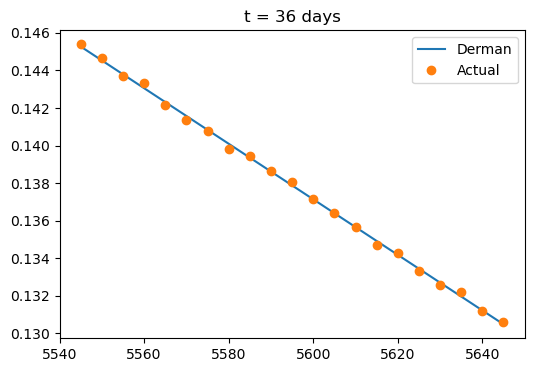

<Figure size 600x400 with 0 Axes>

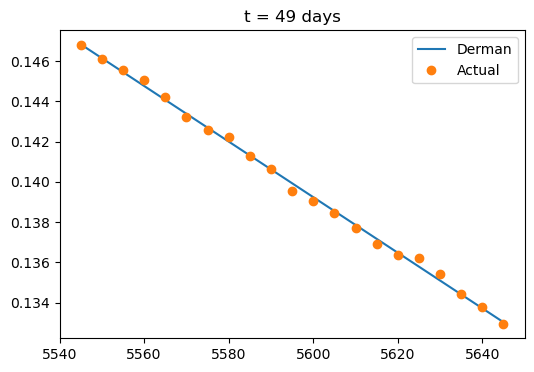

<Figure size 600x400 with 0 Axes>

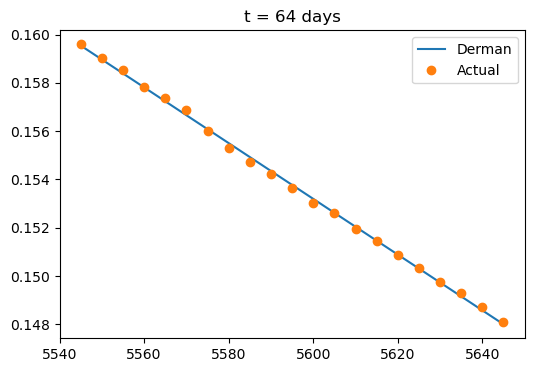

<Figure size 600x400 with 0 Axes>

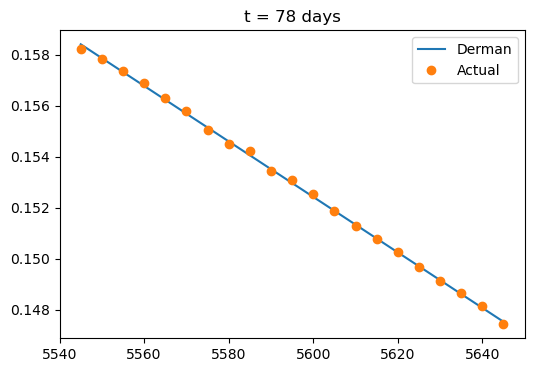

<Figure size 600x400 with 0 Axes>

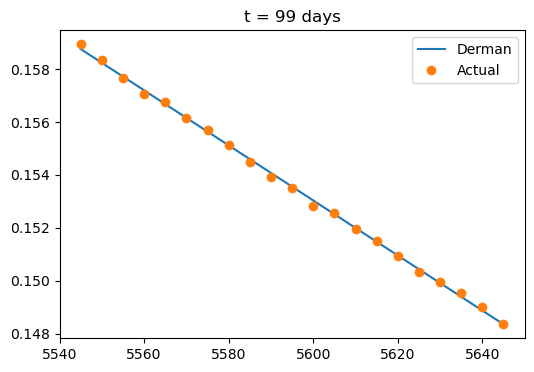

<Figure size 600x400 with 0 Axes>

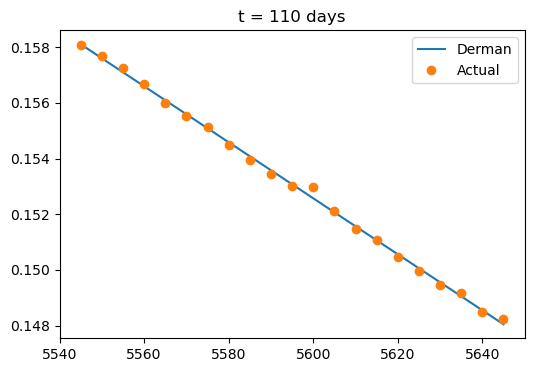

<Figure size 600x400 with 0 Axes>

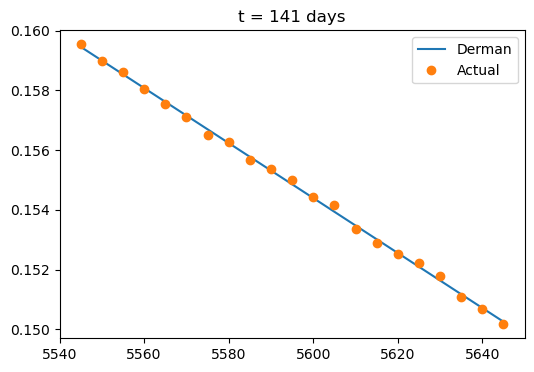

<Figure size 600x400 with 0 Axes>

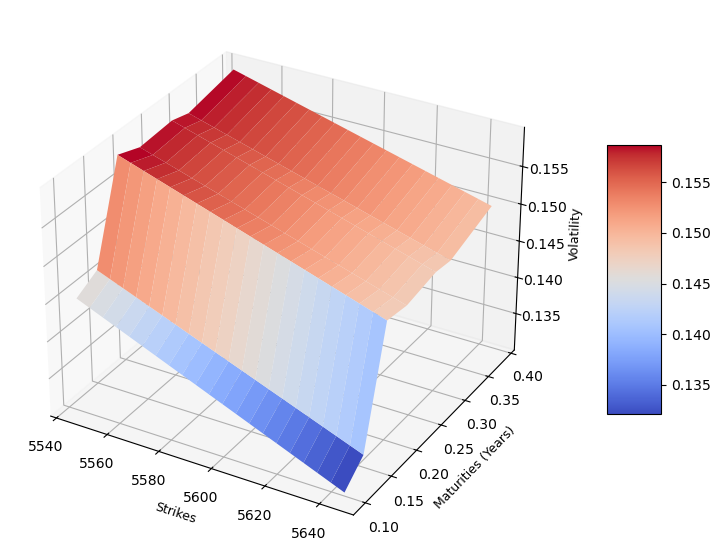


parameters with under 1% pricing error:
                36         49        64        78        99        110  \
S = 5585                                                                 
v0         0.009399   0.020993  0.009931  0.003026  0.000007  0.009761   
kappa     12.286584  15.183797  9.095589  3.078011  1.899882  1.593870   
theta      0.037934   0.028222  0.044094  0.080861  0.109244  0.090200   
rho       -0.801546  -0.792842 -0.775292 -0.765464 -0.766021 -0.764545   
sigma      1.420861   1.716229  1.441382  1.114953  1.103839  0.954867   
error      0.008529   0.004715  0.002014  0.001947  0.001528  0.001342   

               141  
S = 5585            
v0        0.002331  
kappa     2.319120  
theta     0.073903  
rho      -0.771933  
sigma     1.126291  
error     0.000735  


<Figure size 1500x700 with 0 Axes>

In [42]:
start_time = time.time()

S = [s]

heston_dicts = np.empty(len(S),dtype=object)

for s_idx, s in enumerate(S):
    
    ts_df = derman_ts
    K = ts_df.index
    T = ts_df.columns
    
    heston_np_s = np.zeros((6,len(T)),dtype=float)
    heston_df_s = pd.DataFrame(heston_np_s)
    df_s_name = str(f"S = {int(s)}")
    heston_df_s[df_s_name] = ['v0','kappa','theta','rho','sigma','error']
    heston_df_s = heston_df_s.set_index(df_s_name)
    heston_df_s.columns = T
    
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    derK = np.sort(ts_df.index).astype(float)
    derT = np.sort(ts_df.columns).astype(float)
    implied_vols_matrix = ms.make_implied_vols_matrix(derK, derT, ts_df)
    expiration_dates = ms.compute_ql_maturity_dates(derT)
    black_var_surface = ms.make_black_var_surface(
        expiration_dates, derK.astype(float), implied_vols_matrix)
    
    sets_for_maturities = np.empty(len(derT),dtype=object)
    for t_idx, t in enumerate(derT):
        
        risk_free_rate = float(rates_dict['risk_free_rate'].loc[t,0])
        dividend_rate = float(rates_dict['dividend_rate'].loc[t,0])
        flat_ts = ms.make_ts_object(risk_free_rate)
        dividend_ts = ms.make_ts_object(dividend_rate)
        
        v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5; 
        process = ql.HestonProcess(
            flat_ts,                
            dividend_ts,            
            S_handle,               
            v0,                     # Initial volatility
            kappa,                  # Mean reversion speed
            theta,                  # Long-run variance (volatility squared)
            sigma,                  # Volatility of the volatility
            rho                     # Correlation between asset and volatility
        )
        
        model = ql.HestonModel(process)
        engine = ql.AnalyticHestonEngine(model)
        heston_helpers = []
        date = calculation_date + ql.Period(int(t),ql.Days)
        dt = (date - calculation_date)
        p = ql.Period(dt, ql.Days)
                
        for k_idx, k in enumerate(derK):
            sigma = black_var_surface.blackVol(dt/365.25, k) 
            helper = ql.HestonModelHelper(
                p,
                calendar,
                float(s),
                k,
                ql.QuoteHandle(ql.SimpleQuote(sigma)),
                flat_ts,
                dividend_ts)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
        lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
        model.calibrate(heston_helpers, lm,
                          ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))
        theta, kappa, sigma, rho, v0 = model.params()
        
        avg = 0.0
        time.sleep(0.005)
        
        for i in range(min(len(heston_helpers), len(K))):
            opt = heston_helpers[i]
            err = (opt.modelValue() / opt.marketValue() - 1.0)
            
            avg += abs(err)
            
        avg = avg*100.0/len(heston_helpers)
        heston_df_s.loc['theta',t] = theta
        heston_df_s.loc['kappa',t] = kappa
        heston_df_s.loc['sigma',t] = sigma
        heston_df_s.loc['rho',t] = rho
        heston_df_s.loc['v0',t] = v0
        heston_df_s.loc['error',t] = avg/100
        
        heston_params = {
            'theta':theta, 
            'kappa':kappa, 
            'sigma':sigma, 
            'rho':rho, 
            'v0':v0,
            'error': (avg/100,f"{int(t)}D")
            }
        sets_for_maturities[t_idx] = heston_params
        print("-"*40)
        print("Total Average Abs Error (%%) : %5.3f" % (avg))
        print(f"for {int(t)} day maturity\n")
        for key, value in heston_params.items():
            print(f'{key}: {value}')

        print("-"*40)
        
    heston_dicts[s_idx] = sets_for_maturities

end_time = time.time()
runtime = int(end_time-start_time)
print('\nmaturities under \n1% abs error:')

tolerance = 0.01
for i, s in enumerate(heston_dicts):
    for j, t in enumerate(s):
        error = t['error']
        if error[0] < tolerance:
            print("-"*15)
            print(f'error: {round(error[0]*100,4)}%')
            print(f"maturity: {error[1]}")
            print("-"*15)
        else:
            pass


mask = heston_df_s.loc['error', :] < tolerance
heston_df = heston_df_s.loc[:, mask]

from plot_derman import plot_derman_fit
plot_derman_fit()

print(f'\nparameters with under {int(tolerance*100)}% pricing error:\n{heston_df}')